In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import pickle
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
dirlist = os.listdir('./extracted')[:1000]

In [3]:
path_size = 5
def read_prepared_data():
    X = pd.DataFrame()
    y = pd.DataFrame()
    for i,dirname in enumerate(dirlist):
        X_one_image = pd.read_csv('./extracted/'+dirname+'/stacking_data_wosolid.csv')
        X_one_image = X_one_image.iloc[range(0,X_one_image.shape[0],2)]
        X_one_image_solid = pd.read_csv('./extracted/'+dirname+'/stacking_data_osolid.csv')
        X_one_image_solid = X_one_image_solid.iloc[range(0,X_one_image.shape[0],2)]
        X_one_image = pd.concat([X_one_image,X_one_image_solid],axis=1)
        y_one_image = pd.read_csv('./extracted/'+dirname+'/stacking_gt_wosolid.csv')
        y_one_image = y_one_image.iloc[range(0,y_one_image.shape[0],2)]
        X = pd.concat([X,X_one_image],ignore_index=True)  
        y = pd.concat([y,y_one_image],ignore_index=True)
        print(i,dirname,X.shape[0])
    return X,y

In [4]:
feature_list = ['GHS','LK','LLF1','LLF2','LPSS','LST']
label_mark = 'GT'

In [5]:
def read_im_data(dirname,size):
    offset = int((21-int(size))/2)
    size = str(size)
    one_image_data = pd.DataFrame(data=None,columns=feature_list)
    for feature_name in feature_list:
        feature_data = pd.read_csv('./extracted/'+dirname+'/'+size+'/'+feature_name+'.csv',header=-1)
        feature_size = (feature_data.values.shape[0]-offset*2)*(feature_data.values.shape[1]-offset*2)
        if offset!=0:
            one_image_data[feature_name] = list(map(lambda x: x[0],feature_data.values[offset:-offset,offset:-offset].reshape(feature_size,1)))
        else:
            one_image_data[feature_name] = list(map(lambda x: x[0],feature_data.values.reshape(feature_size,1)))
    one_image_labels = pd.read_csv('./extracted/'+dirname+'/'+size+'/'+label_mark+'.csv',header=-1)
    im_size = one_image_labels.shape
    im_size = (im_size[0] - offset*2,im_size[1] - offset*2)
    if offset!=0:
        one_image_labels = list(map(lambda x: x[0],one_image_labels.values[offset:-offset,offset:-offset].reshape(feature_size,1)))
    else:
        one_image_labels = list(map(lambda x: x[0],one_image_labels.values.reshape(feature_size,1)))
    one_image_labels = pd.DataFrame(data=one_image_labels,columns=[label_mark])
    return one_image_data,one_image_labels,im_size

In [92]:
def show_result(y_pred,y_gt,im_size,name):
    y_pred = y_pred.reshape(im_size)
    y_gt = y_gt.reshape(im_size)
    image = sp.misc.imread(open('./images/'+name+'.jpg','rb'),mode='RGB')
    plt.set_cmap('gray')
    plt.figure(1)
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(y_gt)
    plt.subplot(133)
    plt.imshow(y_pred)

In [7]:
%time X,y = read_prepared_data()

0 motion0001 5394
1 motion0002 10416
2 motion0003 14942
3 motion0004 20646
4 motion0005 26350
5 motion0006 31372
6 motion0007 36394
7 motion0008 41416
8 motion0009 46810
9 motion0010 51832
10 motion0011 58342
11 motion0012 65038
12 motion0013 70060
13 motion0014 75082
14 motion0015 80104
15 motion0016 84568
16 motion0017 89590
17 motion0018 94612
18 motion0019 100316
19 motion0020 105710
20 motion0021 111414
21 motion0022 116622
22 motion0023 121644
23 motion0024 126542
24 motion0025 132246
25 motion0026 137268
26 motion0027 142290
27 motion0028 147312
28 motion0029 152334
29 motion0030 157356
30 motion0031 162254
31 motion0032 167958
32 motion0033 172980
33 motion0034 178684
34 motion0035 183706
35 motion0036 188728
36 motion0037 193626
37 motion0038 198648
38 motion0039 203856
39 motion0040 208878
40 motion0041 214582
41 motion0042 218736
42 motion0043 223758
43 motion0044 227974
44 motion0045 233678
45 motion0046 239754
46 motion0047 245830
47 motion0048 250852
48 motion0049 255874


In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(X.index,y.index,test_size=0.30)

In [10]:
classifier_params = pickle.load(open('blur_stacking_separated_solid_params.bin','rb'))

In [11]:
classifier = xgb.XGBClassifier(colsample_bytree=classifier_params['colsample_bytree'],
                               gamma=classifier_params['gamma'],
                               max_depth=classifier_params['max_depth'],
                               min_child_weight=classifier_params['min_child_weight'],
                               n_estimators=classifier_params['n_estimators'],
                               reg_alpha=classifier_params['reg_alpha'],
                               subsample=classifier_params['subsample']                               
                              )

In [12]:
X.ix[X_train_index].shape

(3677406, 225)

In [13]:
y.ix[y_train_index].shape

(3677406, 1)

In [14]:
classifier.fit(X.ix[X_train_index],y.ix[y_train_index])

C:\Programs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.65,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=17, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', reg_alpha=0.01, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.85)

In [15]:
y_gt = np.array(list(map(lambda x: x[0],y.ix[y_test_index].values)))
y_pred_proba = classifier.predict_proba(X.ix[y_test_index])[:,1]
y_pred = classifier.predict(X.ix[y_test_index])

In [16]:
roc_auc_score(y_gt,y_pred_proba)

0.84572463062443293

In [17]:
accuracy_score(y_gt,y_pred)

0.77446777730401417

In [18]:
f1_score(y_gt,y_pred)

0.82208770131419828

In [19]:
from sklearn.metrics import precision_recall_curve

In [20]:
p,r,t = precision_recall_curve(y_gt,y_pred_proba,pos_label = 1)

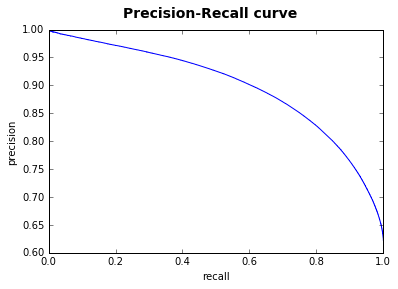

In [21]:
fig = plt.figure()
fig.suptitle('Precision-Recall curve', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.plot(r,p)

In [22]:
classifier.booster().save_model('./stacking_separated_solid.bin')

In [ ]:
booster = xgb.Booster()
booster.load_model('./stacking_separated_solid.bin')
classifier = xgb.XGBClassifier()
classifier._Booster = booster

In [23]:
classifiers={'21': xgb.XGBClassifier(),
             '15': xgb.XGBClassifier(),
             '11': xgb.XGBClassifier()}
classifiers_solid={'21': xgb.XGBClassifier(),
             '15': xgb.XGBClassifier(),
             '11': xgb.XGBClassifier()}

In [24]:
booster21 = xgb.Booster()
booster15 = xgb.Booster()
booster11 = xgb.Booster()
booster21.load_model('./standart_classifiers/classifier21.bin')
booster15.load_model('./standart_classifiers/classifier15.bin')
booster11.load_model('./standart_classifiers/classifier11.bin')
booster21_solid = xgb.Booster()
booster15_solid = xgb.Booster()
booster11_solid = xgb.Booster()
booster21_solid.load_model('./blur_solid_classifiers/classifier21.bin')
booster15_solid.load_model('./blur_solid_classifiers/classifier15.bin')
booster11_solid.load_model('./blur_solid_classifiers/classifier11.bin')

In [25]:
classifiers['21']._Booster = booster21
classifiers['15']._Booster = booster15
classifiers['11']._Booster = booster11
classifiers_solid['21']._Booster = booster21_solid
classifiers_solid['15']._Booster = booster15_solid
classifiers_solid['11']._Booster = booster11_solid

In [26]:
from sklearn.feature_extraction.image import extract_patches_2d
def im2col(image,patch_size):
    patches = extract_patches_2d(image,patch_size)
    return list(map(lambda x: x.reshape(1,patch_size[0]*patch_size[1])[0],patches))

In [27]:
patch_size = 5
def read_test_data(dirname,size,columns,columns_solid):
    size = str(size)
    label_mark = 'y'
    one_image_data,one_image_labels,im_size = read_im_data(dirname,size)
    one_image_result = classifiers[size].predict_proba(one_image_data)
    one_image_result_solid = classifiers_solid[size].predict_proba(one_image_data)

    one_image_blur = one_image_result[:,1].reshape(im_size)
    one_image_clear = one_image_result[:,0].reshape(im_size)
    one_image_solid = one_image_result_solid[:,1].reshape(im_size)
    
    one_image_blur = im2col(one_image_blur,(patch_size,patch_size))
    one_image_clear = im2col(one_image_clear,(patch_size,patch_size))
    one_image_solid = im2col(one_image_solid,(patch_size,patch_size))

    one_image_data = np.hstack((one_image_blur,one_image_clear))
    X = pd.DataFrame(one_image_data,columns=columns)
    X_solid = pd.DataFrame(one_image_solid,columns=columns_solid)

    one_image_labels = one_image_labels.values
    one_image_labels = one_image_labels.reshape(im_size)[int(path_size/2):-int(path_size/2),int(path_size/2):-int(path_size/2)]
    one_image_labels = one_image_labels.reshape(one_image_labels.shape[0]*one_image_labels.shape[1],1)

    y = pd.DataFrame(one_image_labels,columns=[label_mark])
    return X,X_solid,y,im_size

In [28]:
def read_full_test_data(dirname):
    X_full = pd.DataFrame()
    X_full_solid = pd.DataFrame()
    for size in [11,15,21]:
        columns_blur = ['blur'+str(n)+'_'+str(size) for n in range(25)]
        columns_clear = ['clear'+str(n)+'_'+str(size) for n in range(25)]
        columns_solid = ['solid'+str(n)+'_'+str(size) for n in range(25)]
        columns = columns_blur+columns_clear
        X,X_solid,y,im_size = read_test_data(dirname,size,columns,columns_solid)
        X_full = pd.concat([X_full,X],axis =1)
        X_full_solid = pd.concat([X_full_solid,X_solid],axis =1)
    X_full = pd.concat([X_full,X_full_solid],axis =1)
    return X_full,y,im_size

In [85]:
target_name = 'motion0175'

In [86]:
X_test2,y_test2,size = read_full_test_data(target_name)

In [87]:
y_pred = classifier.predict_proba(X_test2)[:,1]

In [88]:
roc_auc_score(y_test2.values,y_pred)

0.91718380573362246

In [95]:
accuracy_score(y_test2.values,y_pred>0.5)

0.79232702325922666

In [101]:
show_result(y_pred,y_test2.values,(size[0]-4,size[1]-4),target_name)

In [53]:
%matplotlib qt